In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.optimize as optim

from itertools import product

# Always make it pretty.
plt.style.use('ggplot')

In [4]:
# Let's make the true data that we will fit. Pretend you didn't see this!!!!
mu = 0.1      #population mean - the real one! (the one we are trying to find)
sigma = 0.9   #population standard deviation - the read one (not 1, btw)
norm = stats.norm(mu, sigma)
data = norm.rvs(100)   # randomly sample 100 data points

In [18]:
# helper functions
def text_in_blank_plot(text, ax):
    _ = ax.text(0.5, 0.5, text, 
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=22)
    ax.axis('off')
    
def one_dim_scatterplot(data, ax, jitter=0.2, **options):
    # jitter is a nice way to show data that's one dimensional and stacked on top of each other
    if jitter:
        jitter = np.random.uniform(-jitter, jitter, size=data.shape)
    else:
        jitter = np.repeat(0.0, len(data))
    ax.scatter(data, jitter, **options)
    ax.yaxis.set_ticklabels([])
    ax.set_ylim([-1, 1])
    
def empirical_distribution(x, data):
    '''Cumulative distribution for the data'''
    weight = 1.0 / len(data)
    count = np.zeros(shape=len(x))
    for datum in data:
        count = count + np.array(x >= datum)
    return weight * count

def log_likelihood_normal_one_parameter(mu):
    normal = stats.norm(mu, 1.0)
    likelihoods = [normal.pdf(datum) for datum in data] # just use pdf for likelihood!
    return np.sum(np.log(likelihoods))

def minus_log_likelihood_normal_one_parameter(mu):
    # optim does gradient descent, not gradient ascent
    return -log_likelihood_normal_one_parameter(mu)

# The optimizer needs a function that consumes a single numpy array
def wrapper_for_scipy_one_parameter(x):
    return minus_log_likelihood_normal_one_parameter(x[0])

fit_parms = optim.minimize(wrapper_for_scipy_one_parameter, (0,), method='Nelder-Mead')
mu_hat = fit_parms.x

def superimpose_pdf_of_fit_model(data, model, ax, x_lower=-3, x_upper=3):
    x = np.linspace(x_lower, x_upper, num=250)
    _ = ax.hist(data, bins=25, density=True, color="black", alpha=0.4)
    ax.plot(x, model.pdf(x), linewidth=3)
    
def superimpose_cdf_of_fit_model(data, model, ax, x_lower=-3, x_upper=3):
    x = np.linspace(x_lower, x_upper, num=250)
    ax.plot(x, empirical_distribution(x, data), linewidth=2)
    ax.plot(x, model.cdf(x), linewidth=2)

### Further (manual) example: Normal Distribution, Unknown Mean and Variance

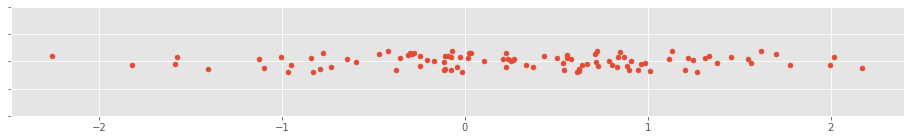

In [7]:
fig, ax = plt.subplots(1, figsize=(16, 2))
one_dim_scatterplot(data, ax, s=25)

And attempt to fit a normal distribution to this data using the likelihood method.

#### Step 1: Write down the model.

Our model contains all normal random variables with varying mean and variance.

$$ M = \{ N(\mu, \sigma^2) \mid \mu \in \mathbb{R}, \sigma^2 \in \mathbb{R}^+ \} $$

#### Step 2: Write down the density functions of all the random variables in the model.

The density function of a normal distribution with unknown mean and variance is:

$$ f(t; \mu, \sigma^2) = \frac{1}{\sqrt{2 \sigma^2 \pi}} e^{ - \frac{(t - \mu)^2}{2 \sigma^2}} $$

This pdf has arguments for both the **data** and the **parameters**:

$$ f(\underbrace{t}_{\text{data}}; \underbrace{\mu, \sigma^2}_{\text{parameters}}) $$

I can access this function in python by using `stats.norm(mu, sigma)`.

#### Step 3: Write code to compute the log likelihood function of the model given the data.

Remember that the data is *fixed* and we want to vary the *parameters*, so the way we write our function should respect that.

In [8]:
def log_likelihood_normal_two_parameters(mu, sigma_sq):
    normal = stats.norm(mu, np.sqrt(sigma_sq))
    likelihoods = [normal.pdf(datum) for datum in data]
    return np.sum(np.log(likelihoods))

As a sanity check, we can evaluate the log-likelihood function at varaious values of the parameters.

In [9]:
for mu, sigma_sq in product([-1, 0, 1], [0.5, 1, 2]):
    print("Log-Lik of Two Parameter Normal Model With mu={0}, sigma_sq={1}: {2:3.2f}".format(
        mu, sigma_sq, log_likelihood_normal_two_parameters(mu, sigma_sq)
    ))

Log-Lik of Two Parameter Normal Model With mu=-1, sigma_sq=0.5: -297.66
Log-Lik of Two Parameter Normal Model With mu=-1, sigma_sq=1: -212.11
Log-Lik of Two Parameter Normal Model With mu=-1, sigma_sq=2: -186.66
Log-Lik of Two Parameter Normal Model With mu=0, sigma_sq=0.5: -142.68
Log-Lik of Two Parameter Normal Model With mu=0, sigma_sq=1: -134.62
Log-Lik of Two Parameter Normal Model With mu=0, sigma_sq=2: -147.91
Log-Lik of Two Parameter Normal Model With mu=1, sigma_sq=0.5: -187.71
Log-Lik of Two Parameter Normal Model With mu=1, sigma_sq=1: -157.13
Log-Lik of Two Parameter Normal Model With mu=1, sigma_sq=2: -159.17


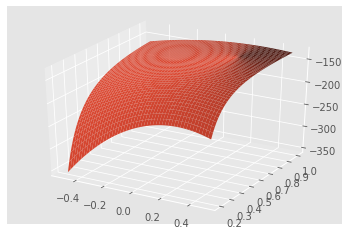

In [10]:
from mpl_toolkits.mplot3d import Axes3D
from pylab import meshgrid

mus = np.linspace(-0.5, 0.5, num=50)
sigmas = np.linspace(0.2, 1.0, num=50)

X, Y = meshgrid(mus, sigmas)
Z = np.array([
        [log_likelihood_normal_two_parameters(mu, sigma_sq)] 
         for mu, sigma_sq in zip(X.flatten(), Y.flatten())]).reshape(X.shape)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z)
plt.show()

It looks like the the log-likelihood is maximized fo mu=0, sigma_sq=0.5, which seems reasonable given the plot of our data.

#### Step 4: Find the parameters that maximize the log-likelihood.

Eyeballing our simple grid search above, it seems like $\mu = 0, \sigma^2 = 0.5$ is the best of what we tried.

Let's use gradient descent to find the maximal parameters.

In [12]:
def minus_log_likelihood_normal_two_parameters(mu, sigma):
    return -log_likelihood_normal_two_parameters(mu, sigma)

# The optimizer needs a function that consumes a single numpy array
def wrapper_for_scipy(x):
    return minus_log_likelihood_normal_two_parameters(x[0], x[1])

fit_parms = optim.minimize(wrapper_for_scipy, (0, 1), method='Nelder-Mead')
mu_hat, sigma_sq_hat = fit_parms.x

print("Log-Lik Optimal Parameters: mu = {0:2.3f}, sigma_sq = {1:2.3f}".format(mu_hat, sigma_sq_hat))

Log-Lik Optimal Parameters: mu = 0.275, sigma_sq = 0.779


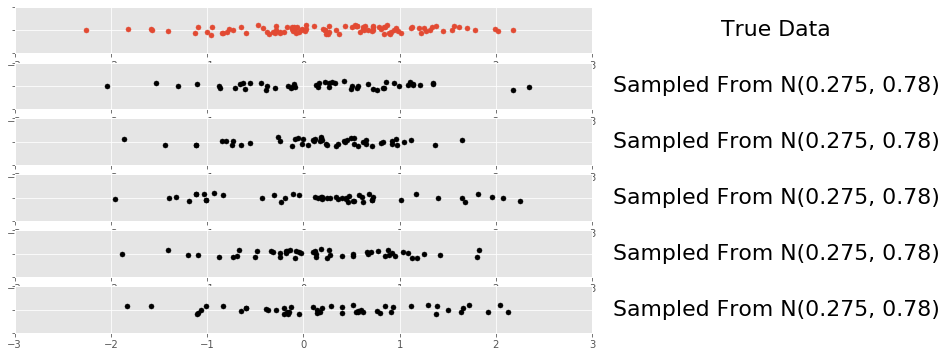

In [13]:
fig = plt.figure(figsize=(16, 6)) 
ax = plt.subplot2grid((6, 3), (0, 0), colspan=2)
ax.set_xlim(-3, 3)
one_dim_scatterplot(data, ax, s=25)
ax = plt.subplot2grid((6, 3), (0, 2), colspan=1)
text_in_blank_plot("True Data", ax)

for i in range(5):
    normal = stats.norm(mu_hat, np.sqrt(sigma_sq_hat))
    sample = normal.rvs(50)
    ax = plt.subplot2grid((6, 3), (i + 1, 0), colspan=2)
    ax.set_xlim(-3, 3)
    one_dim_scatterplot(sample, ax, s=25, c="black")
    ax = plt.subplot2grid((6, 3), (i + 1, 2), colspan=1)
    text_in_blank_plot("Sampled From N({0:0.3f}, {1:0.2f})".format(
                       mu_hat, sigma_sq_hat), ax)

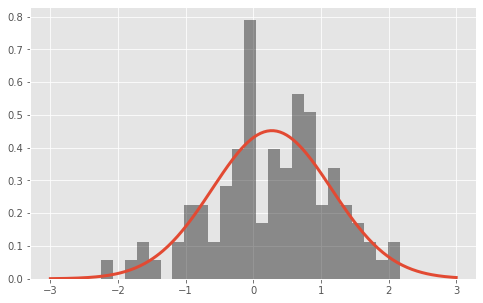

In [14]:
fit_two_param_model = stats.norm(mu_hat, np.sqrt(sigma_sq_hat))

fig, ax = plt.subplots(1, figsize=(8, 5))
superimpose_pdf_of_fit_model(data, fit_two_param_model, ax)

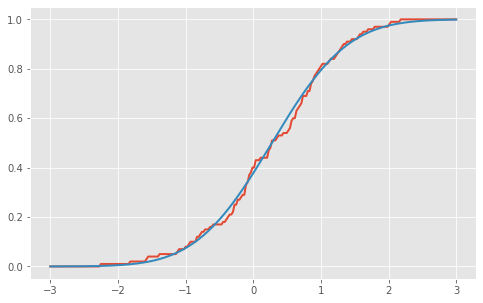

In [19]:
fig, ax = plt.subplots(1, figsize=(8, 5))
superimpose_cdf_of_fit_model(data, fit_two_param_model, ax)

### Are you ever going to have to do this?
In the assignment - yes.  
In practice - no.  In many cases the derivative of the log likelihood function has a [closed-form solution](http://statweb.stanford.edu/~susan/courses/s200/lectures/lect11.pdf), so you can set it equal to zero and solve for the parameters explicitly without trying ranges of parameters.  That's what's happening underneath the hood when you hear MLE is being used.  

But now you hopefully have some understanding of what's going on!